In [19]:
import pandas as pd
import numpy as np

In [20]:
df = pd.read_csv('~/Downloads/3stations-7k.csv')

In [21]:
np.unique(df['station_complex_id'])

array([ 10, 103, 109])

In [22]:
df = df[['transit_timestamp', 'station_complex_id', 'borough', 'fare_class_category', 'ridership']]
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
df.head()

/var/folders/n0/rcf3yt3n5kvfv13rsfyk9fxmm31jrg/T/ipykernel_65671/899050565.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])


,transit_timestamp,station_complex_id,borough,fare_class_category,ridership
0,2024-10-18 16:00:00,10,Manhattan,OMNY - Other,3
1,2024-10-18 23:00:00,10,Manhattan,OMNY - Other,1
2,2024-10-22 14:00:00,10,Manhattan,OMNY - Other,3
3,2024-10-17 11:00:00,10,Manhattan,Metrocard - Fair Fare,9
4,2024-10-17 05:00:00,10,Manhattan,Metrocard - Other,3


In [23]:
#df_10 = df[ df['station_complex_id'] == 10 ].sort_values(by='transit_timestamp')
df_10 = df

In [24]:
import datetime
from sklearn.preprocessing import OneHotEncoder

def prepare(df):
    df = df.copy()
    df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
    df['day_of_week'] = df['transit_timestamp'].dt.dayofweek
    df['hour_of_day'] = df['transit_timestamp'].dt.hour
    df['month_of_year'] = df['transit_timestamp'].dt.month
    df['day_of_month'] = df['transit_timestamp'].dt.day
    df['year'] = df['transit_timestamp'].dt.year
    # df.set_index('transit_timestamp', inplace=True)
    # df = df.drop(['transit_timestamp'], axis=1)
    
    return df

In [25]:
df_10 = prepare(df_10)
df_10

,transit_timestamp,station_complex_id,borough,fare_class_category,ridership,day_of_week,hour_of_day,month_of_year,day_of_month,year
0,2024-10-18 16:00:00,10,Manhattan,OMNY - Other,3,4,16,10,18,2024
1,2024-10-18 23:00:00,10,Manhattan,OMNY - Other,1,4,23,10,18,2024
2,2024-10-22 14:00:00,10,Manhattan,OMNY - Other,3,1,14,10,22,2024
3,2024-10-17 11:00:00,10,Manhattan,Metrocard - Fair Fare,9,3,11,10,17,2024
4,2024-10-17 05:00:00,10,Manhattan,Metrocard - Other,3,3,5,10,17,2024
...,...,...,...,...,...,...,...,...,...,...
724275,2020-07-05 11:00:00,109,Queens,Metrocard - Full Fare,32,6,11,7,5,2020
724276,2020-07-05 19:00:00,109,Queens,Metrocard - Other,4,6,19,7,5,2020
724277,2020-07-05 09:00:00,109,Queens,Metrocard - Unlimited 7-Day,6,6,9,7,5,2020
724278,2020-07-05 09:00:00,109,Queens,Metrocard - Unlimited 30-Day,9,6,9,7,5,2020


In [26]:
def prepare2(df):
    ohe = OneHotEncoder(feature_name_combiner='concat')
    f = ohe.fit_transform(df[['station_complex_id','fare_class_category', 'borough']])

    X_ohe = pd.DataFrame(f.toarray(), columns=ohe.get_feature_names_out())
    
    df = df.drop(['fare_class_category', 'station_complex_id', 'borough'], axis=1)
    # y = df['ridership']
    # X = df.drop(['ridership'], axis=1)
    X = df
    # from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    # scaler = MinMaxScaler()
    # X_scaled = scaler.fit_transform(X)
    # X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
    X =  pd.concat([X, X_ohe], axis=1)
    print(X['ridership'])
    X = X.drop(['transit_timestamp'], axis=1)

    return X #, y

In [27]:
X = prepare2(df_10)

0          3
1          1
2          3
3          9
4          3
          ..
724275    32
724276     4
724277     6
724278     9
724279    21
Name: ridership, Length: 724280, dtype: int64


In [28]:
df_train, df_test = X[(X['year'] <= 2023) &  (X['year'] >= 2022)], X[X['year'] > 2023]

In [29]:
y_train = df_train['ridership']
X_train = df_train.drop(['ridership'], axis=1)

y_test = df_test['ridership']
X_test = df_test.drop(['ridership'], axis=1)

## NN

In [30]:
import warnings
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

In [31]:
from tensorflow.keras.layers import Activation

In [32]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1),
    Activation('elu')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 8s 454us/step - loss: 10912.9727 - val_loss: 1401.1884
Epoch 2/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 8s 442us/step - loss: 13853.0557 - val_loss: 1401.1884
Epoch 3/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 8s 442us/step - loss: 13771.8447 - val_loss: 1401.1884
Epoch 4/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 7s 422us/step - loss: 13410.8213 - val_loss: 1401.1884
Epoch 5/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 7s 410us/step - loss: 13954.7646 - val_loss: 1401.1884
Epoch 6/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 7s 404us/step - loss: 13454.8213 - val_loss: 1401.1884
Epoch 7/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 7s 426us/step - loss: 13372.8633 - val_loss: 1401.1884
Epoch 8/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 7s 433us/step - loss: 13350.9951 - val_loss: 1401.1884
Epoch 9/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 7s 416us/step - loss: 13703.1602 - val_loss: 1401.1884
Epoch 10/100
17290/17290 ━━━━━━━━━━━━━━━━━━━━ 7s 415us/step - loss: 13656.7988 - val_loss: 1401.1884

In [86]:
model.evaluate(X_test, y_test, verbose=1)

AttributeError: 'XGBRegressor' object has no attribute 'evaluate'

In [87]:
preds = model.predict(X_test)
r2_score(y_test, preds)

0.8794282078742981

4694/4694 ━━━━━━━━━━━━━━━━━━━━ 1s 224us/step


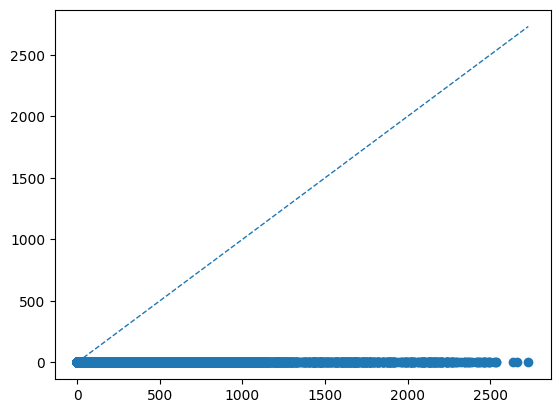

In [69]:
ground_predicted(model)

In [43]:
import matplotlib.pyplot as plt
def ground_predicted(mdl, desc=''):
    y_hat = mdl.predict(X_test)

    #fig, ax = plt.subplots()

    #plt.figure(figsize=(20, 20))
    
    plt.scatter(y_test, y_hat)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=1)
    
    #ax.set_xlabel('Actual (Ground Truth)')
    #ax.set_ylabel('Predicted')
    #ax.set_title(f"Ground Truth vs Predicted | {desc}")

## XGBoost

In [88]:
df_train

,ridership,day_of_week,hour_of_day,month_of_year,day_of_month,year,station_complex_id_10,station_complex_id_103,station_complex_id_109,fare_class_category_Metrocard - Fair Fare,...,fare_class_category_Metrocard - Students,fare_class_category_Metrocard - Unlimited 30-Day,fare_class_category_Metrocard - Unlimited 7-Day,fare_class_category_OMNY - Fair Fare,fare_class_category_OMNY - Full Fare,fare_class_category_OMNY - Other,fare_class_category_OMNY - Seniors & Disability,fare_class_category_OMNY - Students,borough_Manhattan,borough_Queens
32996,14,4,6,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32997,53,4,10,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32998,16,4,12,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32999,75,4,11,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
33000,410,4,23,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708830,2,6,5,12,25,2022,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708831,21,6,14,12,25,2022,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708832,2,6,0,12,25,2022,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
708833,4,6,13,12,25,2022,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [89]:
from xgboost import XGBRegressor

In [90]:
model = XGBRegressor(n_estimators=1500, early_stopping_rounds=50, max_depth=7, learning_rate=0.01)

In [91]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

[0]	validation_0-rmse:96.16828	validation_1-rmse:134.75885
[10]	validation_0-rmse:88.14187	validation_1-rmse:125.76687
[20]	validation_0-rmse:80.97987	validation_1-rmse:117.77538
[30]	validation_0-rmse:74.56486	validation_1-rmse:110.58932
[40]	validation_0-rmse:68.84661	validation_1-rmse:104.23504
[50]	validation_0-rmse:63.74817	validation_1-rmse:98.59552
[60]	validation_0-rmse:59.17961	validation_1-rmse:93.54366
[70]	validation_0-rmse:55.11033	validation_1-rmse:89.16808
[80]	validation_0-rmse:51.49160	validation_1-rmse:85.34301
[90]	validation_0-rmse:48.25692	validation_1-rmse:81.93379
[100]	validation_0-rmse:45.42301	validation_1-rmse:79.01134
[110]	validation_0-rmse:42.87165	validation_1-rmse:76.29926
[120]	validation_0-rmse:40.55949	validation_1-rmse:73.80571
[130]	validation_0-rmse:38.55173	validation_1-rmse:71.58938
[140]	validation_0-rmse:36.78001	validation_1-rmse:69.60080
[150]	validation_0-rmse:35.18243	validation_1-rmse:67.72077
[160]	validation_0-rmse:33.74697	validation_1-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [92]:
pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_)

,0
day_of_week,0.037638
hour_of_day,0.121430
month_of_year,0.019128
day_of_month,0.003002
year,0.071224
station_complex_id_10,0.205094
station_complex_id_103,0.016332
station_complex_id_109,0.002999
fare_class_category_Metrocard - Fair Fare,0.002552
fare_class_category_Metrocard - Full Fare,0.136414


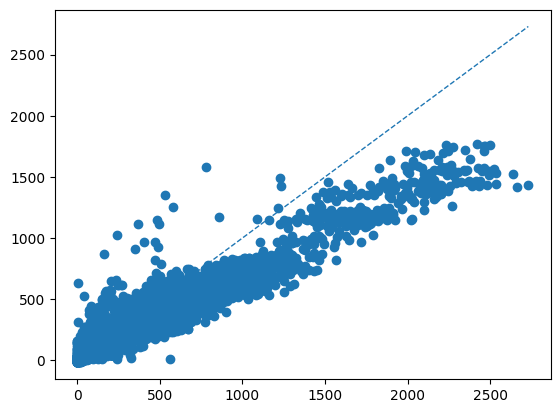

In [93]:
ground_predicted(model)

In [94]:
preds = model.predict(X_test)

In [95]:
from sklearn.metrics import r2_score

In [96]:
r2_score(y_test, preds)

0.8794282078742981

In [97]:
tplot = df_test.copy()

In [98]:
df_train.head()

,ridership,day_of_week,hour_of_day,month_of_year,day_of_month,year,station_complex_id_10,station_complex_id_103,station_complex_id_109,fare_class_category_Metrocard - Fair Fare,...,fare_class_category_Metrocard - Students,fare_class_category_Metrocard - Unlimited 30-Day,fare_class_category_Metrocard - Unlimited 7-Day,fare_class_category_OMNY - Fair Fare,fare_class_category_OMNY - Full Fare,fare_class_category_OMNY - Other,fare_class_category_OMNY - Seniors & Disability,fare_class_category_OMNY - Students,borough_Manhattan,borough_Queens
32996,14,4,6,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32997,53,4,10,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32998,16,4,12,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32999,75,4,11,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
33000,410,4,23,2,11,2022,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [99]:
tplot.head()

,ridership,day_of_week,hour_of_day,month_of_year,day_of_month,year,station_complex_id_10,station_complex_id_103,station_complex_id_109,fare_class_category_Metrocard - Fair Fare,...,fare_class_category_Metrocard - Students,fare_class_category_Metrocard - Unlimited 30-Day,fare_class_category_Metrocard - Unlimited 7-Day,fare_class_category_OMNY - Fair Fare,fare_class_category_OMNY - Full Fare,fare_class_category_OMNY - Other,fare_class_category_OMNY - Seniors & Disability,fare_class_category_OMNY - Students,borough_Manhattan,borough_Queens
0,3,4,16,10,18,2024,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,4,23,10,18,2024,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,1,14,10,22,2024,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,9,3,11,10,17,2024,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,3,5,10,17,2024,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [100]:
def predict(r):
    print(r)
    return model.predict(r[['day_of_week', 'hour_of_day', 'month_of_year', 'day_of_month', 'year', 'station_complex_id_10', 'station_complex_id_103', 'station_complex_id_109', 'fare_class_category_Metrocard - Fair Fare', 'fare_class_category_Metrocard - Full Fare', 'fare_class_category_Metrocard - Other', 'fare_class_category_Metrocard - Seniors & Disability', 'fare_class_category_Metrocard - Students', 'fare_class_category_Metrocard - Unlimited 30-Day', 'fare_class_category_Metrocard - Unlimited 7-Day', 'fare_class_category_OMNY - Fair Fare', 'fare_class_category_OMNY - Full Fare', 'fare_class_category_OMNY - Other', 'fare_class_category_OMNY - Seniors & Disability', 'fare_class_category_OMNY - Students', 'borough_Manhattan', 'borough_Queens']])

In [101]:
tplot['predicted'] = tplot.apply(predict, axis=1)

ridership                                                  3.0
day_of_week                                                4.0
hour_of_day                                               16.0
month_of_year                                             10.0
day_of_month                                              18.0
year                                                    2024.0
station_complex_id_10                                      1.0
station_complex_id_103                                     0.0
station_complex_id_109                                     0.0
fare_class_category_Metrocard - Fair Fare                  0.0
fare_class_category_Metrocard - Full Fare                  0.0
fare_class_category_Metrocard - Other                      0.0
fare_class_category_Metrocard - Seniors & Disability       0.0
fare_class_category_Metrocard - Students                   0.0
fare_class_category_Metrocard - Unlimited 30-Day           0.0
fare_class_category_Metrocard - Unlimited 7-Day        

ValueError: feature_names mismatch: ['day_of_week', 'hour_of_day', 'month_of_year', 'day_of_month', 'year', 'station_complex_id_10', 'station_complex_id_103', 'station_complex_id_109', 'fare_class_category_Metrocard - Fair Fare', 'fare_class_category_Metrocard - Full Fare', 'fare_class_category_Metrocard - Other', 'fare_class_category_Metrocard - Seniors & Disability', 'fare_class_category_Metrocard - Students', 'fare_class_category_Metrocard - Unlimited 30-Day', 'fare_class_category_Metrocard - Unlimited 7-Day', 'fare_class_category_OMNY - Fair Fare', 'fare_class_category_OMNY - Full Fare', 'fare_class_category_OMNY - Other', 'fare_class_category_OMNY - Seniors & Disability', 'fare_class_category_OMNY - Students', 'borough_Manhattan', 'borough_Queens'] ['0']
expected fare_class_category_Metrocard - Seniors & Disability, station_complex_id_10, station_complex_id_103, borough_Manhattan, day_of_month, fare_class_category_Metrocard - Unlimited 30-Day, fare_class_category_OMNY - Fair Fare, fare_class_category_OMNY - Students, fare_class_category_OMNY - Seniors & Disability, station_complex_id_109, year, fare_class_category_Metrocard - Other, fare_class_category_Metrocard - Fair Fare, fare_class_category_Metrocard - Students, day_of_week, fare_class_category_OMNY - Full Fare, month_of_year, borough_Queens, fare_class_category_Metrocard - Full Fare, fare_class_category_Metrocard - Unlimited 7-Day, hour_of_day, fare_class_category_OMNY - Other in input data
training data did not have the following fields: 0

In [103]:
tplot['month'] = tplot['month_of_year']
tplot['day'] = tplot['day_of_month']
tplot['hour'] = tplot['hour_of_day']

tplot['timestamp'] = pd.to_datetime(tplot[['year', 'month', 'day', 'hour']])

In [104]:
tplot = tplot.set_index('timestamp')

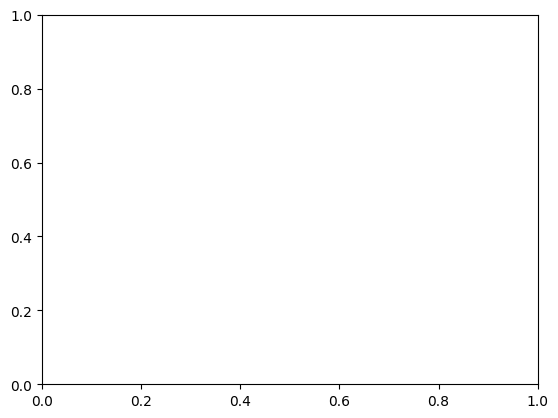

In [105]:
fig, ax = plt.subplots()

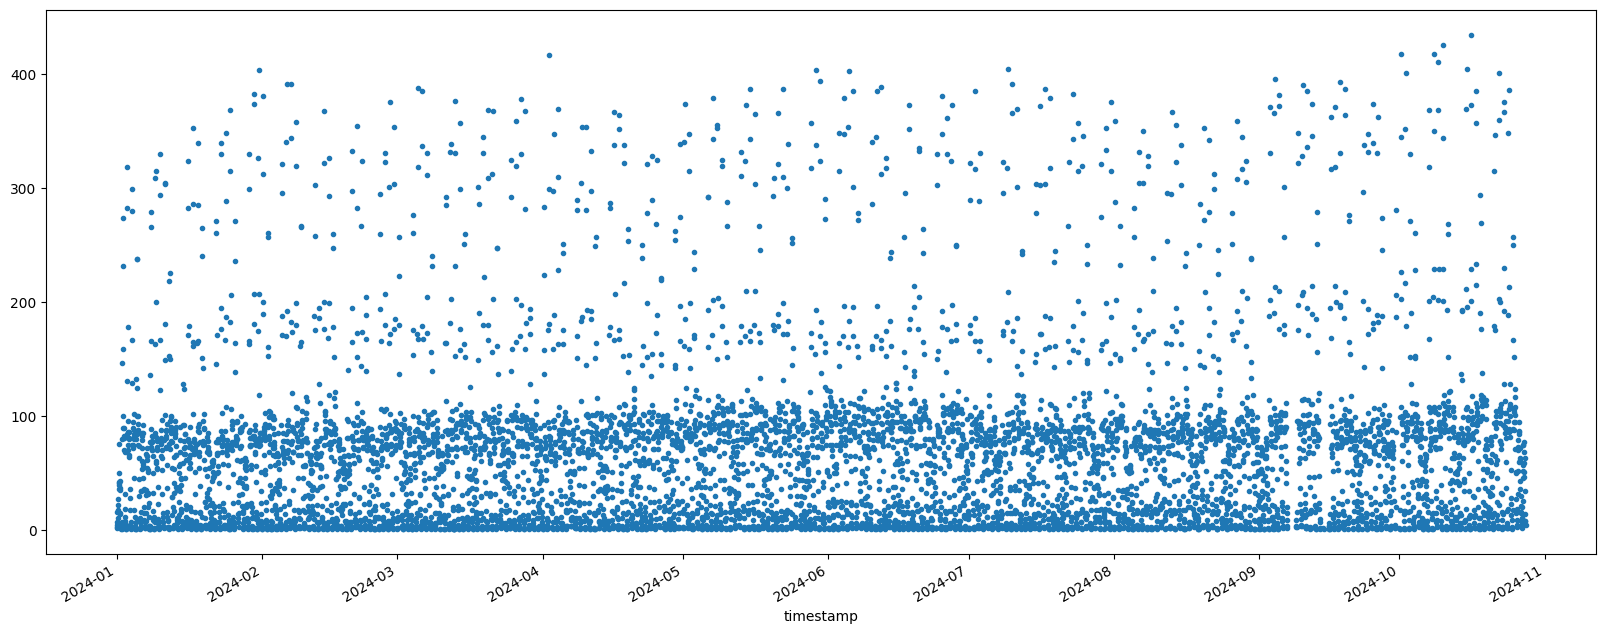

In [106]:
ax = tplot[(tplot['fare_class_category_OMNY - Full Fare'] == 1.0) & (tplot['station_complex_id_109'] == 1.0)]['ridership'].plot(style='.',figsize=(20,8))

In [107]:
tplot['predicted'] = tplot.apply(model.predict, axis=1)


ValueError: feature_names mismatch: ['day_of_week', 'hour_of_day', 'month_of_year', 'day_of_month', 'year', 'station_complex_id_10', 'station_complex_id_103', 'station_complex_id_109', 'fare_class_category_Metrocard - Fair Fare', 'fare_class_category_Metrocard - Full Fare', 'fare_class_category_Metrocard - Other', 'fare_class_category_Metrocard - Seniors & Disability', 'fare_class_category_Metrocard - Students', 'fare_class_category_Metrocard - Unlimited 30-Day', 'fare_class_category_Metrocard - Unlimited 7-Day', 'fare_class_category_OMNY - Fair Fare', 'fare_class_category_OMNY - Full Fare', 'fare_class_category_OMNY - Other', 'fare_class_category_OMNY - Seniors & Disability', 'fare_class_category_OMNY - Students', 'borough_Manhattan', 'borough_Queens'] ['2024-10-18 16:00:00']
expected fare_class_category_Metrocard - Seniors & Disability, station_complex_id_10, station_complex_id_103, borough_Manhattan, day_of_month, fare_class_category_Metrocard - Unlimited 30-Day, fare_class_category_OMNY - Fair Fare, fare_class_category_OMNY - Students, fare_class_category_OMNY - Seniors & Disability, station_complex_id_109, year, fare_class_category_Metrocard - Other, fare_class_category_Metrocard - Fair Fare, fare_class_category_Metrocard - Students, day_of_week, fare_class_category_OMNY - Full Fare, month_of_year, borough_Queens, fare_class_category_Metrocard - Full Fare, fare_class_category_Metrocard - Unlimited 7-Day, hour_of_day, fare_class_category_OMNY - Other in input data
training data did not have the following fields: 2024-10-18 16:00:00

/var/folders/n0/rcf3yt3n5kvfv13rsfyk9fxmm31jrg/T/ipykernel_65671/3257939091.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='hour_of_day', y='ridership', ax=axes[0], ci=None)
/var/folders/n0/rcf3yt3n5kvfv13rsfyk9fxmm31jrg/T/ipykernel_65671/3257939091.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='month_of_year', y='ridership', ax=axes[2], ci=None)


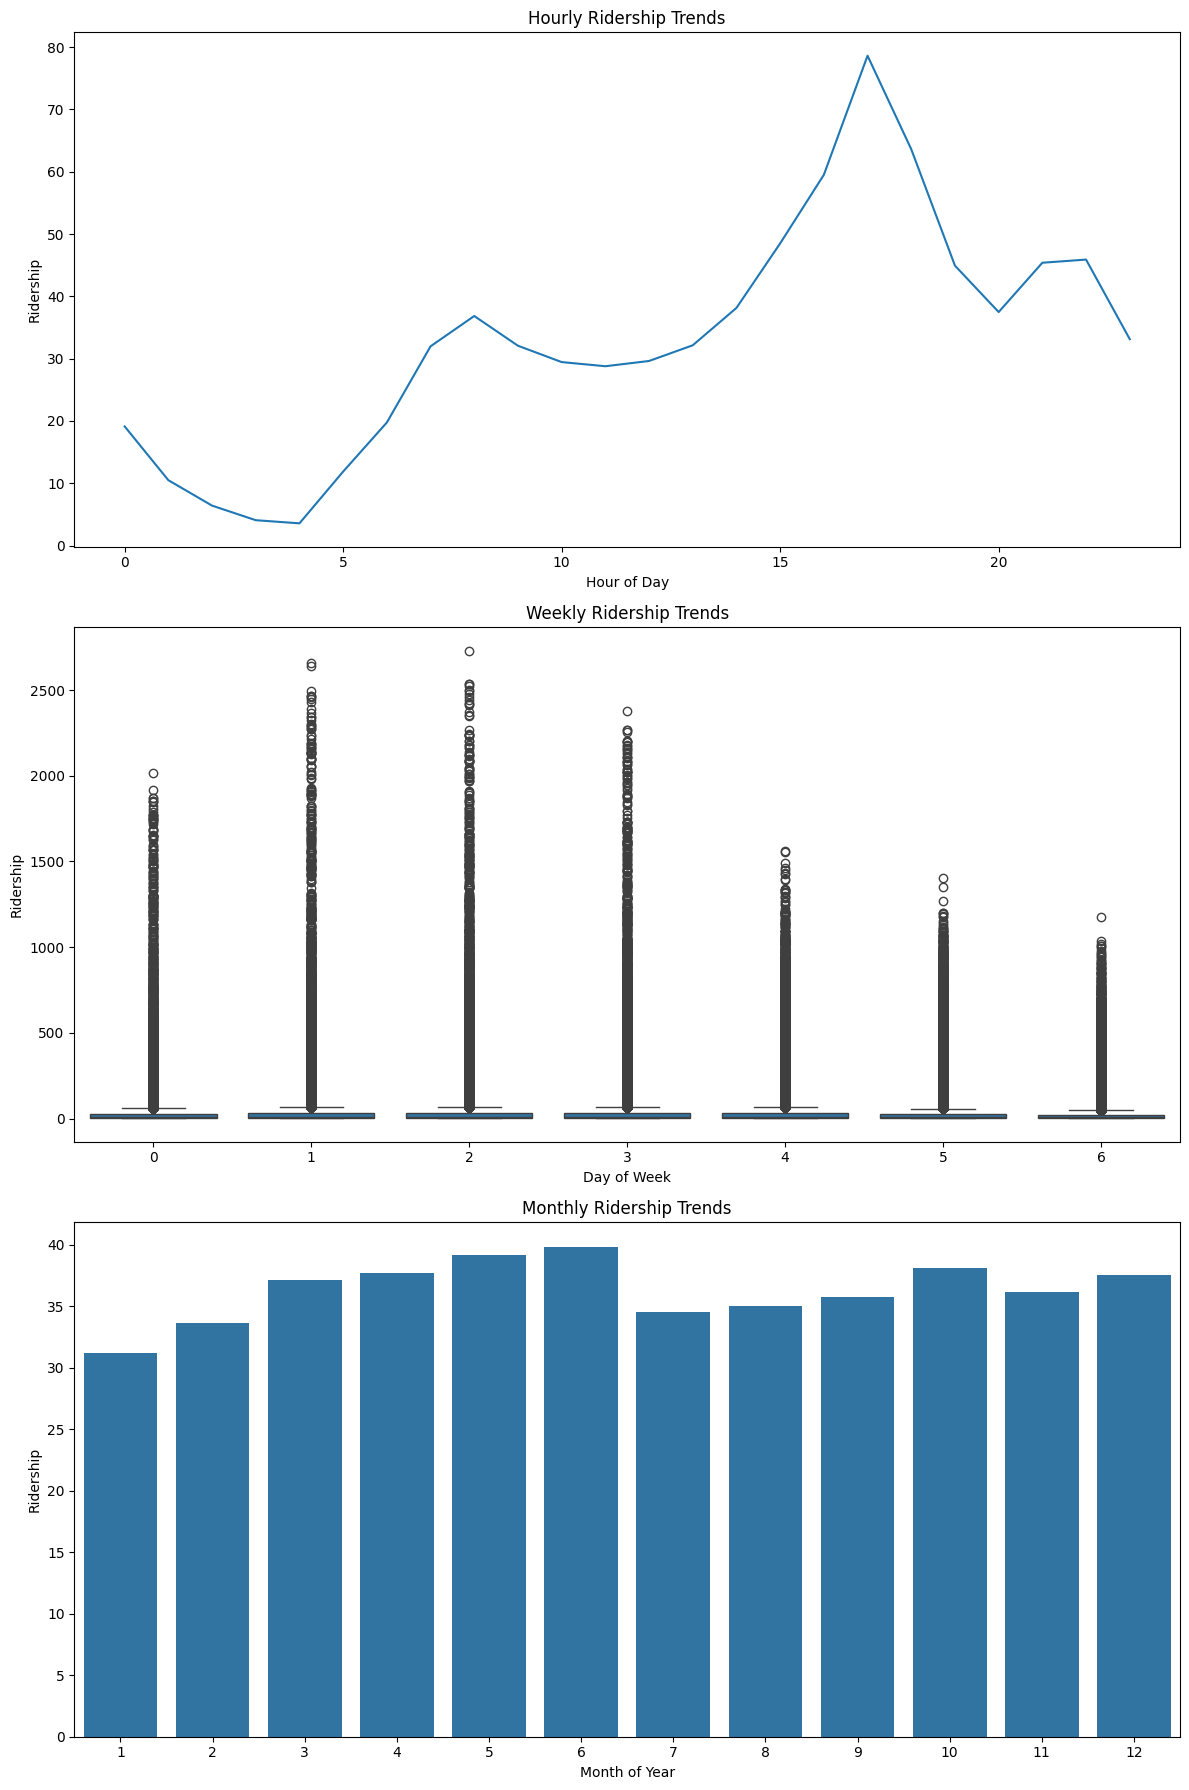

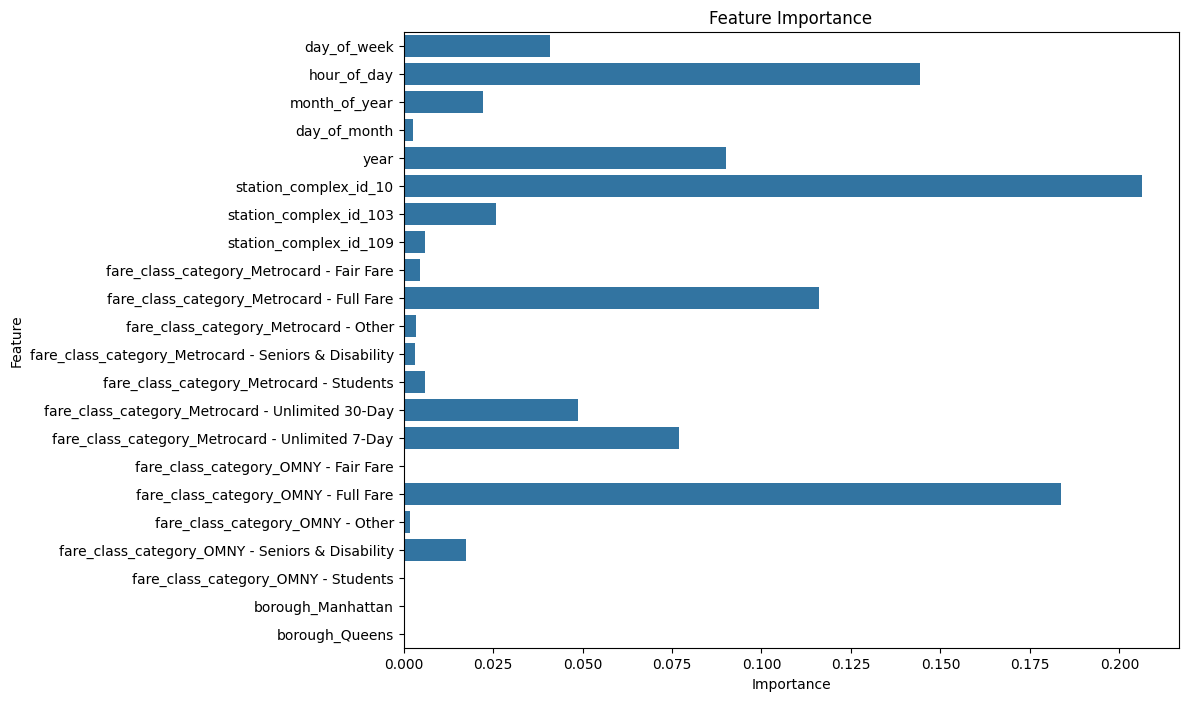

In [142]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

def plot_ridership_trends(df):
    if 'transit_timestamp' not in df or 'ridership' not in df:
        print("Error: 'transit_timestamp' or 'ridership' column is missing in the dataframe.")
        return

    df['hour_of_day'] = df['transit_timestamp'].dt.hour
    df['day_of_week'] = df['transit_timestamp'].dt.dayofweek
    df['month_of_year'] = df['transit_timestamp'].dt.month

    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    sns.lineplot(data=df, x='hour_of_day', y='ridership', ax=axes[0], ci=None)
    axes[0].set_title('Hourly Ridership Trends')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Ridership')

    sns.boxplot(data=df, x='day_of_week', y='ridership', ax=axes[1])
    axes[1].set_title('Weekly Ridership Trends')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Ridership')

    sns.barplot(data=df, x='month_of_year', y='ridership', ax=axes[2], ci=None)
    axes[2].set_title('Monthly Ridership Trends')
    axes[2].set_xlabel('Month of Year')
    axes[2].set_ylabel('Ridership')

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model):
    try:
        importance = model.feature_importances_
        features = model.feature_names_in_
    except AttributeError:
        print("Error: Model does not have feature importances.")
        return

    plt.figure(figsize=(10, 8))
    sns.barplot(x=importance, y=features, orient='h')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()



plot_ridership_trends(df)
model = XGBRegressor().fit(X_train, y_train)
plot_feature_importance(model)



Available Station IDs: [ 10 103 109]
2020-07-01 00:00:00
2024-10-27 23:00:00


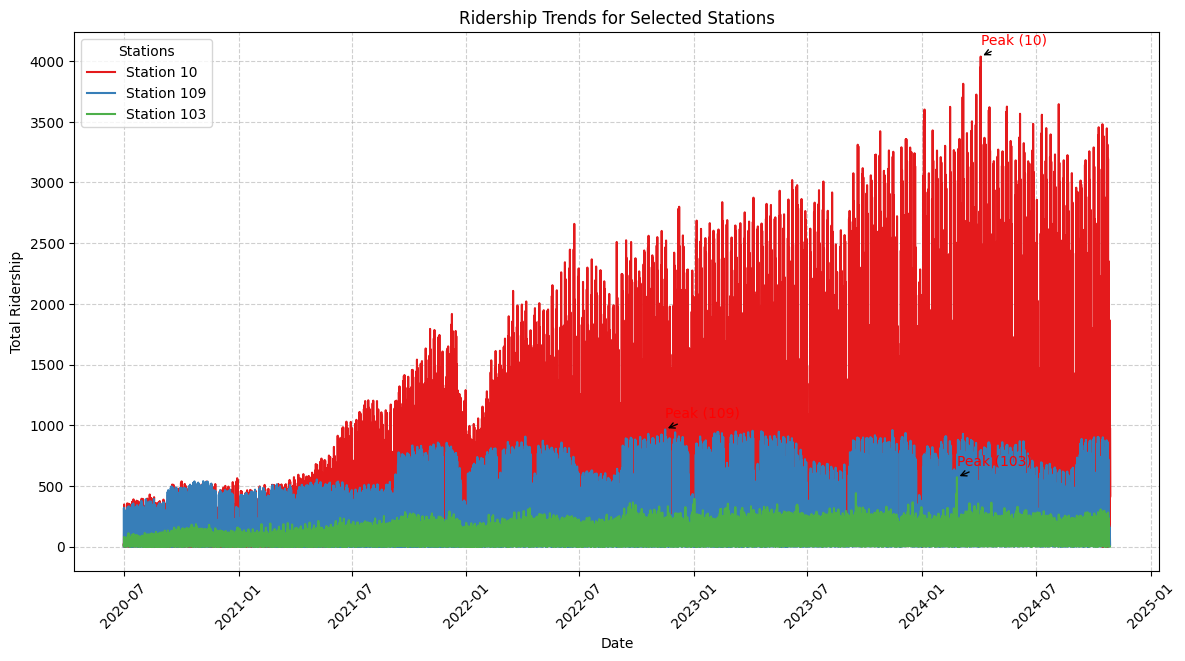

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ridership_by_line(df, line_station_ids):
    if 'station_complex_id' not in df or 'ridership' not in df or 'transit_timestamp' not in df:
        print("Error: Necessary columns are missing in the dataframe.")
        return

    line_df = df[df['station_complex_id'].isin(line_station_ids)]
    if line_df.empty:
        print("Error: No data for the specified station line IDs.")
        return

    line_df_grouped = line_df.groupby(['station_complex_id', 'transit_timestamp'])['ridership'].sum().reset_index()

    plt.figure(figsize=(14, 7))

    color_palette = sns.color_palette("Set1", len(line_station_ids))

    for i, station_id in enumerate(line_station_ids):
        station_data = line_df_grouped[line_df_grouped['station_complex_id'] == station_id]
        
        sns.lineplot(data=station_data, x='transit_timestamp', y='ridership', label=f'Station {station_id}', color=color_palette[i])

        if not station_data.empty:
            peak_idx = station_data['ridership'].idxmax()
            peak_time = station_data.loc[peak_idx, 'transit_timestamp']
            peak_value = station_data.loc[peak_idx, 'ridership']

            plt.annotate(
                f'Peak ({station_id})',
                xy=(peak_time, peak_value),
                xytext=(peak_time, peak_value + 100),
                arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=10,
                color='red'
            )

    plt.title('Ridership Trends for Selected Stations')
    plt.xlabel('Date')
    plt.ylabel('Total Ridership')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend(title='Stations')
    plt.show()

plot_ridership_by_line(df, line_station_ids=[10, 109, 103])



In [138]:
print(df_test.columns)



Index(['ridership', 'day_of_week', 'hour_of_day', 'month_of_year',
       'day_of_month', 'year', 'station_complex_id_10',
       'station_complex_id_103', 'station_complex_id_109',
       'fare_class_category_Metrocard - Fair Fare',
       'fare_class_category_Metrocard - Full Fare',
       'fare_class_category_Metrocard - Other',
       'fare_class_category_Metrocard - Seniors & Disability',
       'fare_class_category_Metrocard - Students',
       'fare_class_category_Metrocard - Unlimited 30-Day',
       'fare_class_category_Metrocard - Unlimited 7-Day',
       'fare_class_category_OMNY - Fair Fare',
       'fare_class_category_OMNY - Full Fare',
       'fare_class_category_OMNY - Other',
       'fare_class_category_OMNY - Seniors & Disability',
       'fare_class_category_OMNY - Students', 'borough_Manhattan',
       'borough_Queens'],
      dtype='object')


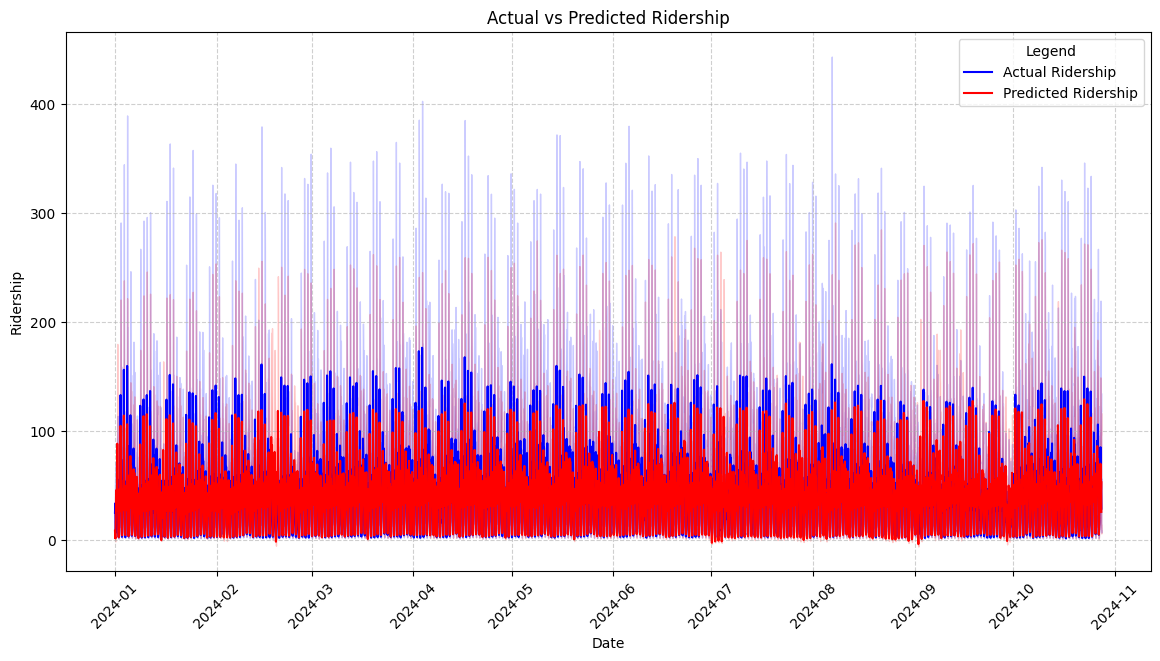

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp']) 


df_test = df.iloc[y_test.index]


comparison_df = pd.DataFrame({
    'transit_timestamp': df_test['transit_timestamp'],  
    'actual': y_test,                                  
    'predicted': preds                                
})

plt.figure(figsize=(14, 7))
sns.lineplot(data=comparison_df, x='transit_timestamp', y='actual', label='Actual Ridership', color='blue')
sns.lineplot(data=comparison_df, x='transit_timestamp', y='predicted', label='Predicted Ridership', color='red')

plt.title("Actual vs Predicted Ridership")
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Legend')

plt.show()



In [108]:
for idx in range(len(y_test)):
    if abs(y_test.iloc[idx] - preds[idx]) > 500:
        print(X_test.iloc[idx][['day_of_week', 'hour_of_day']])
        print('---')
        print(y_test.iloc[idx], preds[idx])
        print()

day_of_week     2.0
hour_of_day    16.0
Name: 55, dtype: float64
---
1305 735.4512

day_of_week     2.0
hour_of_day    18.0
Name: 77, dtype: float64
---
1914 1186.461

day_of_week     3.0
hour_of_day    18.0
Name: 167, dtype: float64
---
1673 1147.2306

day_of_week     3.0
hour_of_day    17.0
Name: 181, dtype: float64
---
2204 1358.1019

day_of_week     1.0
hour_of_day    17.0
Name: 426, dtype: float64
---
2282 1506.9479

day_of_week     0.0
hour_of_day    17.0
Name: 783, dtype: float64
---
1766 1154.9163

day_of_week     3.0
hour_of_day    17.0
Name: 946, dtype: float64
---
2112 1363.3972

day_of_week     2.0
hour_of_day    17.0
Name: 1189, dtype: float64
---
2372 1467.3163

day_of_week     3.0
hour_of_day    17.0
Name: 1311, dtype: float64
---
1986 1341.4211

day_of_week     4.0
hour_of_day    17.0
Name: 1507, dtype: float64
---
1317 782.8618

day_of_week     1.0
hour_of_day    19.0
Name: 1715, dtype: float64
---
1181 650.35156

day_of_week     1.0
hour_of_day    17.0
Name: 1838, dty